In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns 
import datetime
from datetime import timedelta

In [2]:
!pip install xgboost

  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, precision_score, f1_score, recall_score, r2_score, make_scorer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

import xgboost as xgb

from sklearn.cluster import KMeans

In [4]:
data = pd.read_csv('energy_activities_2019_2022.csv')

In [5]:
df = data.loc[(data['sector_category'] == 'Services')&(data['postal_code'] == 8002)].copy()
df = df.loc[(df['time_range'] == '00:00-05:59')|(df['time_range'] == '18:00-23:59')].copy()
df['year_observed'] = df['year_observed'].astype(str)
df['postal_code'] = df['postal_code'].astype(str)
df['year_observed_int'] = df['year_observed'].astype(int)
df = df.reset_index()
df = df.drop(['index','sector_category'], axis=1)

In [6]:
def eliminar_primer_caracter(texto):
    if texto.startswith('0'):
        return texto[1:]
    else:
        return texto

df['location'] = df['location'].apply(eliminar_primer_caracter)

In [7]:
condiciones = [
    (df['postal_code'] == df['location']),
    (df['location'] == 'Several places'),
    (df['location'] == 'Unknown'),
    (df['location'] == 'None')
]
valores = ['Delimited zone', 'Several places', 'Unknown', 'Unknown']
df['event_location'] = np.select(condiciones, valores, default='No event')
df = df.drop(['postal_code', 'location'], axis=1)

In [8]:
conteo_valores = df['event_location'].value_counts()
#print(conteo_valores)

In [9]:
grupos = [df[i:i+2] for i in range(0, len(df), 2)]

In [10]:
datos = pd.concat([grupo.iloc[0:1].assign(value_day=grupo['consumption_value'].sum()) for grupo in grupos], ignore_index=True)
datos = datos.drop(['time_range','consumption_value'], axis=1)
datos.rename(columns={'value_day': 'consumption_value'}, inplace=True)

In [11]:
#datos.head()

In [12]:
# Ordena el DataFrame por la columna 'fecha' en orden ascendente
df=datos.copy()
df['date_observed'] = pd.to_datetime(df['date_observed'])
df.sort_values(by='date_observed', inplace=True)

# Calcula la media de 'valor' para la misma fecha en años anteriores
df['average_past'] = df.groupby(df['date_observed'].dt.dayofyear)['consumption_value'].transform(lambda x: x.shift().expanding().mean())
df['average_past'].fillna(df['average_past'].mean(numeric_only=True), inplace=True)

margen_superior = df['average_past'] * 0.05
margen_inferior = df['average_past'] * 0.05

# Ahora puedes verificar si el valor actual está dentro de la media de años anteriores
df['valor_dentro_de_media'] = np.where((df['consumption_value'] >= df['average_past'] - margen_inferior) &
                                       (df['consumption_value'] <= df['average_past'] + margen_superior), 'Average', 'Not Average')

df['average_type'] = np.where((df['valor_dentro_de_media'] == 'Not Average') & 
                                      (df['consumption_value'] > df['average_past']), 'Above Average',
                                      np.where((df['valor_dentro_de_media'] == 'Not Average') & 
                                               (df['consumption_value'] < df['average_past']), 'Below Average', 'Average'))

Text(0.5, 0, 'Consumption Value (KWatts)')

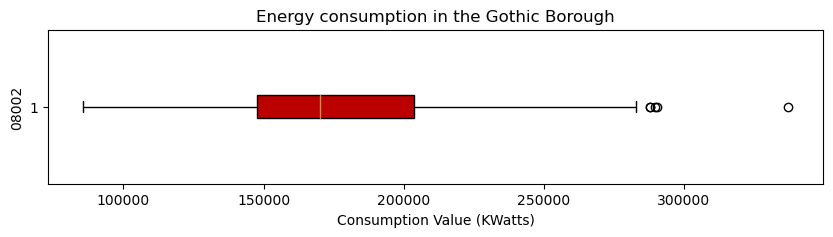

In [13]:
fig, axs = plt.subplots(figsize=(10,2))
sns.set_theme(style="white",font='serif')
axs.boxplot(df.loc[:,'consumption_value'], patch_artist=True, boxprops={'facecolor': '#BB0000'}, vert=False)
axs.set_title("Energy consumption in the Gothic Borough")
plt.ylabel('08002')
plt.xlabel('Consumption Value (KWatts)')

In [14]:
def data2ts(idate, fdate):
    df_test = None
    try:
        ts = df[["date_observed", "consumption_value"]]
        ts = ts[(ts['date_observed'] >= idate) & (ts['date_observed'] < fdate)]
        #df_test = ts.set_index(ts['dateObserved']).asfreq('1Min')
        df_test = ts.set_index(ts['date_observed'])
        df_test = df_test[~df_test.index.duplicated(keep='first')]
        df_test = df_test.asfreq('1D')
        df_test = df_test.drop(columns = ["date_observed"])
    except Exception as e:
        print("Error:", e)
    return(df_test)

In [15]:
df['date_observed'] = df['date_observed'].dt.tz_localize('UTC')

df['date_observed'] = df['date_observed'].dt.tz_convert('Europe/Madrid')

# Crea objetos datetime64[ns] a partir de fechas y horas específicas
s_idate = np.datetime64('2022-03-31T00:00:00', 'ns')
s_fdate = np.datetime64('2023-03-31T00:00:00', 'ns')

start_date = np.datetime64('2022-03-31T00:00:00', 'ns')

# Convierte a Timestamp y luego asegúrate de que estén en UTC
start_time = pd.Timestamp(s_idate).tz_localize('UTC').tz_convert('Europe/Madrid')
end_time = pd.Timestamp(s_fdate).tz_localize('UTC').tz_convert('Europe/Madrid')

In [16]:
ts_energy = data2ts(start_time, end_time)

Error: Cannot infer dst time from 2022-10-30 02:00:00, try using the 'ambiguous' argument


In [17]:
#ts_energy.head(100)

In [18]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    sns.set_theme(style="white",font='serif')
    plt.figure(figsize=(10,5), dpi=dpi)
    plt.plot(x, y, color='#BB0000')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.axhline(y=y.mean(), color='black', linestyle='-')
    plt.ylabel('Consumption Value (KWatts)')
    plt.show()

In [19]:
#plot_df(ts_energy, x=ts_energy.index, y=ts_energy.consumption_value, title="Energy consumption in the Gothic Borough") 

In [20]:
def featureEng(dataFrame):
    df_ts = dataFrame.copy()
    df_ts['day'] = df_ts.index.dayofweek
    df_ts['week'] = df_ts.index.to_series().dt.isocalendar().week
    df_ts['month'] = df_ts.index.to_series().dt.month
    df_ts['sin_day'] = np.sin(2 * np.pi * df_ts['day'] / 7)
    df_ts['cos_day'] = np.cos(2 * np.pi * df_ts['day'] / 7)
    df_ts['sin_week'] = np.sin(2 * np.pi * df_ts['week'] / 52)
    df_ts['cos_week'] = np.cos(2 * np.pi * df_ts['week'] / 52)
    df_ts['sin_month'] = np.sin(2 * np.pi * df_ts['month'] / 12)
    df_ts['cos_month'] = np.cos(2 * np.pi * df_ts['month'] / 12)
    df_ts = df_ts.sort_index()
    df_ts = df_ts.resample('D').first()
    df_ts.reset_index(drop=True, inplace=True)
    df_ts.dropna(inplace=True)
    return df_ts

In [21]:
fe_ts_energy = df.copy()
fe_ts_energy = fe_ts_energy[fe_ts_energy['date_observed'] < '2023-01-01']
fe_ts_energy = fe_ts_energy.set_index("date_observed")
fe_ts_energy = featureEng(fe_ts_energy)

In [22]:
from sklearn.linear_model import LinearRegression

def fitModel(fe_df):
    X = fe_df[['sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month']].values.reshape(-1, 6)
    y = fe_df['consumption_value']
    model = LinearRegression().fit(X, y)
    return model

In [23]:
model_fe_ts_energy = fitModel(fe_ts_energy)

In [24]:
def generatePredictions(modelFitted, fe_df):
    n_predictions = 360 * 24 * 60 # 15 days worth of seconds
    pred_index = np.arange(n_predictions) * 60
    timestamps = [pd.Timestamp(start_date) + pd.Timedelta(seconds=x) for x in pred_index]
    df_pred = pd.DataFrame({'timestamp': timestamps})
    df_pred['day'] = df_pred['timestamp'].dt.dayofweek
    df_pred['week'] = df_pred['timestamp'].dt.isocalendar().week
    df_pred['month'] = df_pred['timestamp'].dt.month
    df_pred['sin_day'] = np.sin(2 * np.pi * df_pred['day'] / 7)
    df_pred['cos_day'] = np.cos(2 * np.pi * df_pred['day'] / 7)
    df_pred['sin_week'] = np.sin(2 * np.pi * df_pred['week'] / 52)
    df_pred['cos_week'] = np.cos(2 * np.pi * df_pred['week'] / 52)
    df_pred['sin_month'] = np.sin(2 * np.pi * df_pred['month'] / 12)
    df_pred['cos_month'] = np.cos(2 * np.pi * df_pred['month'] / 12)
    X_pred = df_pred[['sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month']].values.reshape(-1, 6)
    predictions = modelFitted.predict(X_pred.reshape(-1, 6))
    pred_df = pd.DataFrame({'consumption_value': predictions}, index=timestamps)
    pred_df['date_forecasted'] = pred_df.index
    pred_df = pred_df.groupby(pred_df.index.date).agg({
        'date_forecasted': 'mean',  
        'consumption_value': 'mean' 
    }).reset_index()
    pred_df = pred_df.drop('date_forecasted', axis = 1)
    pred_df.rename(columns={'index': 'date_forecasted'}, inplace=True)
    pred_df['date_forecasted'] = pd.to_datetime(pred_df['date_forecasted'])
    return pred_df

In [25]:
predictions_energy = generatePredictions(model_fe_ts_energy,fe_ts_energy)

In [26]:
pd.options.display.float_format = '{:.2f}'.format
#print(predictions_energy)

In [27]:
#plot_df(predictions_energy, x=predictions_energy.date_forecasted, y=predictions_energy.consumption_value, title="Forecasted") 

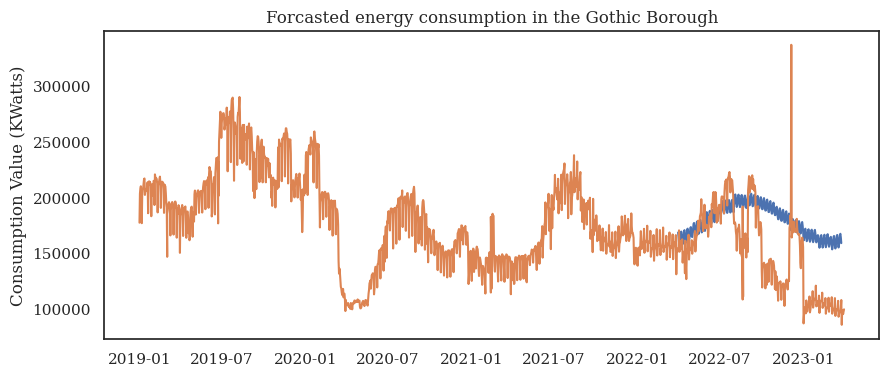

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(predictions_energy.date_forecasted, predictions_energy.consumption_value,df.date_observed, df.consumption_value)
plt.ylabel('Consumption Value (KWatts)')
plt.title('Forcasted energy consumption in the Gothic Borough')
plt.show()

In [29]:
# Filtrar las filas donde 'valor_dentro_de_media' es 'Average'.
average_rows = df[df['valor_dentro_de_media'] == 'Average']

# Filtrar las filas donde 'valor_dentro_de_media' es 'Not Average'.
not_average_rows = df[df['valor_dentro_de_media'] == 'Not Average']

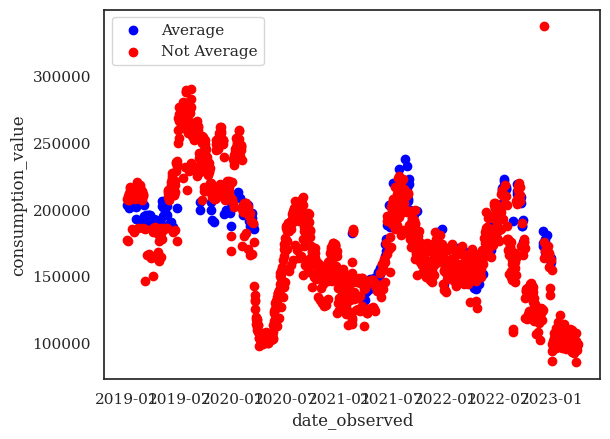

In [30]:
# Crear un gráfico de dispersión para las filas 'Average'.
plt.scatter(average_rows['date_observed'], average_rows['consumption_value'], label='Average', color='blue')

# Crear un gráfico de dispersión para las filas 'Not Average'.
plt.scatter(not_average_rows['date_observed'], not_average_rows['consumption_value'], label='Not Average', color='red')

# Establecer etiquetas de los ejes.
plt.xlabel('date_observed')
plt.ylabel('consumption_value')

# Agregar una leyenda para distinguir entre 'Average' y 'Not Average'.
plt.legend()

# Mostrar el gráfico.
plt.show()

In [31]:
predictions_energy['day_of_week'] = predictions_energy['date_forecasted'].dt.strftime('%A')

predictions_energy['month'] = predictions_energy['date_forecasted'].dt.strftime('%B')

In [32]:
pred_energy = predictions_energy.copy()

In [33]:
pred_energy['date_forecasted'] = pd.to_datetime(pred_energy['date_forecasted']).dt.tz_localize(None).dt.date
df['date_observed'] = pd.to_datetime(df['date_observed']).dt.tz_convert('Europe/Madrid').dt.date

In [34]:
def fecha_anterior(fecha):
    return fecha - pd.DateOffset(years=1)

pred_energy['last_year'] = pred_energy['date_forecasted'].apply(fecha_anterior)

In [35]:
pred_energy['date_forecasted'] = pd.to_datetime(pred_energy['date_forecasted'])
df['date_observed'] = pd.to_datetime(df['date_observed'])
pred_energy = pred_energy.merge(df[['date_observed','average_past','organizers_type','event_location']], how='left', left_on='last_year', right_on='date_observed')

In [36]:
#pred_energy

In [37]:
pred_energy = pred_energy.drop(['last_year','date_observed'], axis=1)

In [38]:
margen_superior = pred_energy['average_past'] * 0.05
margen_inferior = pred_energy['average_past'] * 0.05

pred_energy['valor_dentro_de_media'] = np.where((pred_energy['consumption_value'] >= pred_energy['average_past'] - margen_inferior) &
                                       (pred_energy['consumption_value'] <= pred_energy['average_past'] + margen_superior), 'Average', 'Not Average')

pred_energy['average_type'] = np.where((pred_energy['valor_dentro_de_media'] == 'Not Average') & 
                                      (pred_energy['consumption_value'] > pred_energy['average_past']), 'Above Average',
                                      np.where((pred_energy['valor_dentro_de_media'] == 'Not Average') & 
                                               (pred_energy['consumption_value'] < pred_energy['average_past']), 'Below Average', 'Average'))

# Filtrar las filas donde 'valor_dentro_de_media' es 'Average'.
average_rows = pred_energy[pred_energy['valor_dentro_de_media'] == 'Average']

# Filtrar las filas donde 'valor_dentro_de_media' es 'Not Average'.
not_average_rows = pred_energy[pred_energy['valor_dentro_de_media'] == 'Not Average']

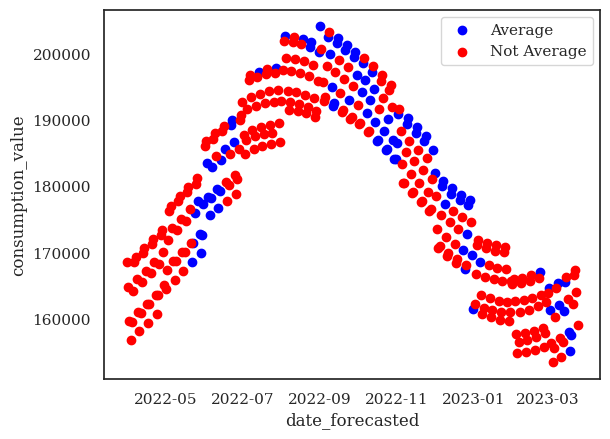

In [39]:
# Crear un gráfico de dispersión para las filas 'Average'.
plt.scatter(average_rows['date_forecasted'], average_rows['consumption_value'], label='Average', color='blue')

# Crear un gráfico de dispersión para las filas 'Not Average'.
plt.scatter(not_average_rows['date_forecasted'], not_average_rows['consumption_value'], label='Not Average', color='red')

# Establecer etiquetas de los ejes.
plt.xlabel('date_forecasted')
plt.ylabel('consumption_value')

# Agregar una leyenda para distinguir entre 'Average' y 'Not Average'.
plt.legend()

# Mostrar el gráfico.
plt.show()

In [40]:
fecha_inicio = pd.to_datetime('2023-01-01')
fecha_fin = pd.to_datetime('2023-03-25')

# Crea una máscara booleana para las filas que están dentro del rango
mascara = (df['date_observed'] >= fecha_inicio) & (df['date_observed'] <= fecha_fin)

# Aplica la máscara al DataFrame para filtrar las filas
df_validate = df[mascara]

In [41]:
y_validate=df_validate['valor_dentro_de_media'].copy()
y_validate = y_validate.values

In [42]:
fecha_inicio = pd.to_datetime('2019-01-01')
fecha_fin = pd.to_datetime('2022-12-31')

# Crea una máscara booleana para las filas que están dentro del rango
mascara = (df['date_observed'] >= fecha_inicio) & (df['date_observed'] <= fecha_fin)

# Aplica la máscara al DataFrame para filtrar las filas
df_train = df[mascara]

In [43]:
#df_train.describe(include='all',datetime_is_numeric=True)

In [44]:
#df_train = df.loc[df['year_observed_int'] < 2023]
df_train = df_train.drop(['date_observed','year_observed_int'], axis=1)
X_train=df_train.copy()
X_train=X_train.drop(columns='valor_dentro_de_media')
y_train=df_train['valor_dentro_de_media'].copy()

In [45]:
#y_train.head()

In [46]:
X1 = pd.get_dummies(X_train,prefix=['year_observed'], columns = ['year_observed'])
X2 = pd.get_dummies(X1,prefix=['day_of_week'], columns = ['day_of_week'])
X3 = pd.get_dummies(X2,prefix=['month'], columns = ['month'])
X4 = pd.get_dummies(X3,prefix=['organizers_type'], columns = ['organizers_type'])
X5 = pd.get_dummies(X4,prefix=['event_location'], columns = ['event_location'])
X6 = pd.get_dummies(X5,prefix=['average_type'], columns = ['average_type'])
X_pre=X6.copy()

In [47]:
#X_pre.head()

In [48]:
scaler = MinMaxScaler()

In [49]:
X_scaled_train = pd.DataFrame(scaler.fit_transform(X_pre[X_pre.columns].values),columns=X_pre.columns, index=X_pre.index)

In [50]:
#X_scaled_train.head()

In [51]:
#pred_energy.describe(include='all',datetime_is_numeric=True)

In [52]:
fecha_inicio = pd.to_datetime('2023-01-01')
fecha_fin = pd.to_datetime('2023-03-25')

pred_energy['year_observed'] = '2023'
# Crea una máscara booleana para las filas que están dentro del rango
mascara = (pred_energy['date_forecasted'] >= fecha_inicio) & (pred_energy['date_forecasted'] <= fecha_fin)

# Aplica la máscara al DataFrame para filtrar las filas
pred_filtered = pred_energy[mascara]

In [53]:
df_test = pred_filtered[['year_observed', 'day_of_week', 'month','organizers_type','event_location','consumption_value','average_past', 'average_type']]
X_test=df_test.copy()

In [54]:
#X_test

In [55]:
X1test = pd.get_dummies(X_test,prefix=['year_observed'], columns = ['year_observed'])
X2test = pd.get_dummies(X1test,prefix=['day_of_week'], columns = ['day_of_week'])
X3test = pd.get_dummies(X2test,prefix=['month'], columns = ['month'])
X4test = pd.get_dummies(X3test,prefix=['organizers_type'], columns = ['organizers_type'])
X5test = pd.get_dummies(X4test,prefix=['event_location'], columns = ['event_location'])
X6test = pd.get_dummies(X5test,prefix=['average_type'], columns = ['average_type'])
X_pretest=X6test.copy()
#X_pretest.head()

In [56]:
newColumn=np.zeros(len(X_pretest),dtype=np.int8)
columns_to_insert_X_pretest = ['year_observed_2019','year_observed_2020','year_observed_2021','year_observed_2022','organizers_type_Private','organizers_type_Public','organizers_type_Hybrid','month_April','month_May','month_June','month_July','month_August','month_September','month_October','month_November','month_December','event_location_Delimited zone', 'event_location_No event','event_location_Several places']
for col_name in columns_to_insert_X_pretest:
    X_pretest[col_name] = newColumn

In [57]:
X_scaled_test = pd.DataFrame(scaler.fit_transform(X_pretest[X_pretest.columns].values),columns=X_pretest.columns, index=X_pretest.index)
X_scaled_test = X_scaled_test[['consumption_value', 'average_past', 'year_observed_2019',
       'year_observed_2020', 'year_observed_2021', 'year_observed_2022',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'organizers_type_Hybrid',
       'organizers_type_Private', 'organizers_type_Public',
       'organizers_type_Unknown', 'event_location_Delimited zone',
       'event_location_No event', 'event_location_Several places',
       'event_location_Unknown', 'average_type_Above Average',
       'average_type_Average', 'average_type_Below Average','year_observed_2023']]
X_scaled_test['consumption_value'].fillna(X_scaled_test['consumption_value'].mean(numeric_only=True), inplace=True)
X_scaled_test['average_past'].fillna(X_scaled_test['average_past'].mean(numeric_only=True), inplace=True)
#X_scaled_test.head()

In [58]:
#print(X_scaled_test.isna().sum())

In [59]:
#df_energy_test = df.loc[df['year_observed_int'] == 2023].copy()

In [60]:
#df_energy_test['date_observed'] = pd.to_datetime(df_energy_test['date_observed'])

# Extrae solo la fecha (sin hora) y calcula la media
#df_energy_test['date_observed'] = df_energy_test['date_observed'].dt.date
#df_energy_test = df_energy_test.groupby('date_observed')['consumption_value'].mean().reset_index()

In [61]:
#df_energy_test

In [138]:
!pip install statsmodels

In [139]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

Les hipòtesis d'aquest segon test son:

* H_0: la sèrie temporal presenta una arrel unitària i, per tant, no és estacionària
* H_1: la sèrie temporal NO presenta cap arrel unitària i, per tant, és estacionària

In [140]:
df_ts_energy = df.copy()
df_ts_energy['date_observed'] = pd.to_datetime(df_ts_energy['date_observed'], format='%Y-%m-%d')
df_ts_energy.sort_values(by='date_observed', inplace=True)
df_ts_energy.set_index('date_observed', inplace=True)

df_ts_energy['date'] = df_ts_energy.index.date

# Group by date and calculate the sum of 'consumption_value'
df_ts_energy = df_ts_energy.groupby('date')['consumption_value'].sum().reset_index()

In [141]:
print(df_ts_energy.index)

RangeIndex(start=0, stop=1551, step=1)


In [145]:
result = adfuller(df_ts_energy)

# Imprime los resultados
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')
print(f'Lags utilizados: {result[2]}')
print(f'Valores críticos: {result[4]}')

ValueError: x is required to have ndim 1 but has ndim 2

Estadístico ADF: -3.9789548077150867

Valor p: 0.0015248090038454789

Lags utilizados: 22

Valores críticos: {'1%': -3.4349056408696814, '5%': -2.863552005375758, '10%': -2.5678411776130114}

El p-valor (0.001) és més petit que 0.05. Conseqüentment, existeix suficient evidència estadística com per rebutjar la hipòtesi nul·la i determinar que ens trobem davant d'una ST estacionària.

In [ ]:
pip install numpy scipy

In [146]:
def sax(series, num_segments, alphabet_size):
    segment_length = len(series) // num_segments
    symbols = []
    for i in range(0, len(series), segment_length):
        segment = series[i:i+segment_length]
        avg_value = np.mean(segment)
        symbol = int((avg_value - min(series)) / (max(series) - min(series)) * alphabet_size)
        symbols.append(symbol)
    return symbols

In [147]:
num_segments = 12
alphabet_size = 24

symbols = sax(ts_energy, num_segments, alphabet_size)
print(symbols)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('float64'), dtype('<U17')) -> None

In [ ]:
p, d, q = 2, 2, 2  
P, D, Q, s = 2, 2, 2, 12 

sarima_model = sm.tsa.SARIMAX(df_ts_energy['consumption_value'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

In [ ]:
df_ts_energy['date'] = df_ts_energy['date']  # Reemplaza 'tus_fechas_originales' con la columna de fechas original
df.set_index('date', inplace=True)

In [ ]:
forecast_steps = 12  # Número de pasos a predecir en el futuro
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [ ]:
print(df_ts_energy.index)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_ts_energy['date'], df_ts_energy['consumption_value'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=True))
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Energy consumption')
plt.xticks(rotation=45)
plt.show()

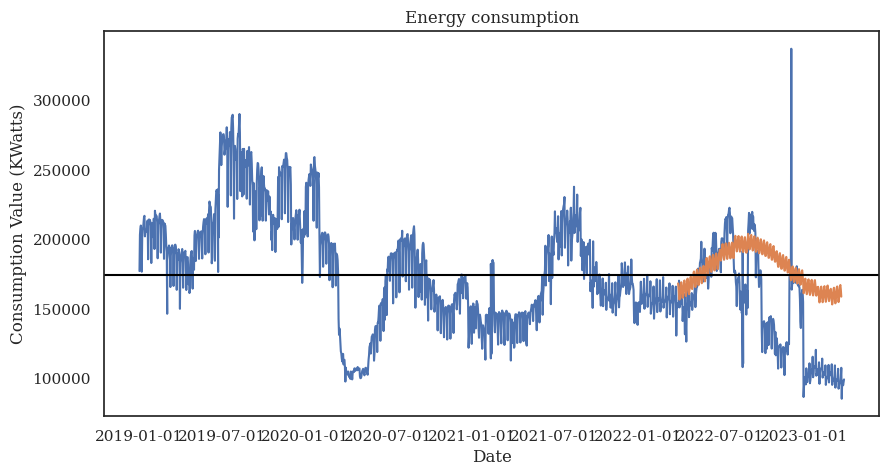

In [65]:
sns.set_theme(style="white",font='serif')
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df.date_observed, df.consumption_value, predictions_energy.date_forecasted, predictions_energy.consumption_value)
plt.gca().set(title='Energy consumption', xlabel='Date', ylabel='Consumption Value (KWatts)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=True))
plt.axhline(y=df.consumption_value.mean(), color='black', linestyle='-')
plt.show()

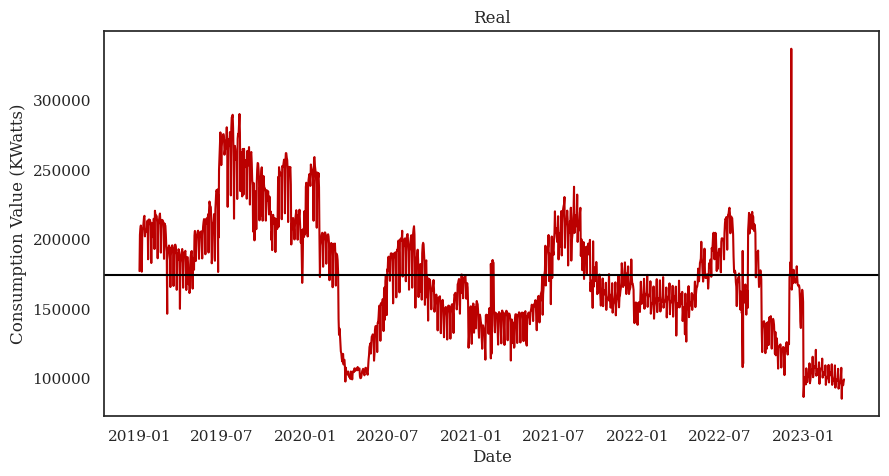

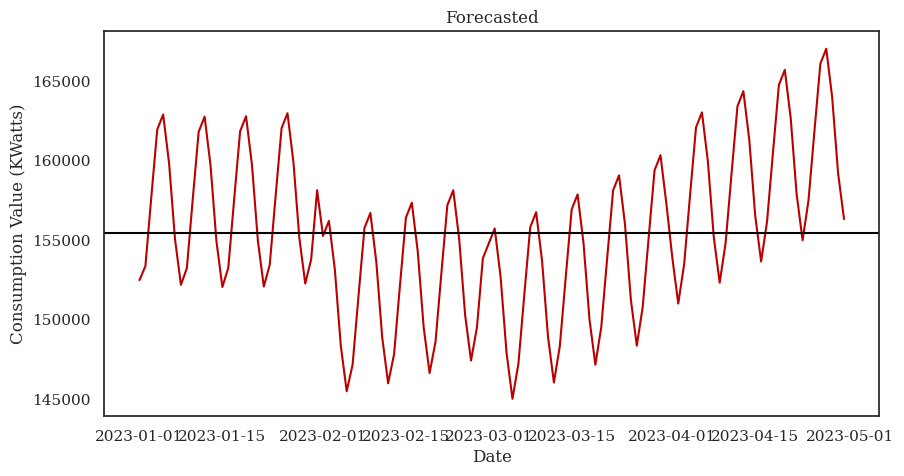

In [48]:
plot_df(df, x=df.index, y=df.consumption_value, title="Real") 
plot_df(predictions_energy, x=predictions_energy.date_forecasted, y=predictions_energy.consumption_value, title="Forecasted") 

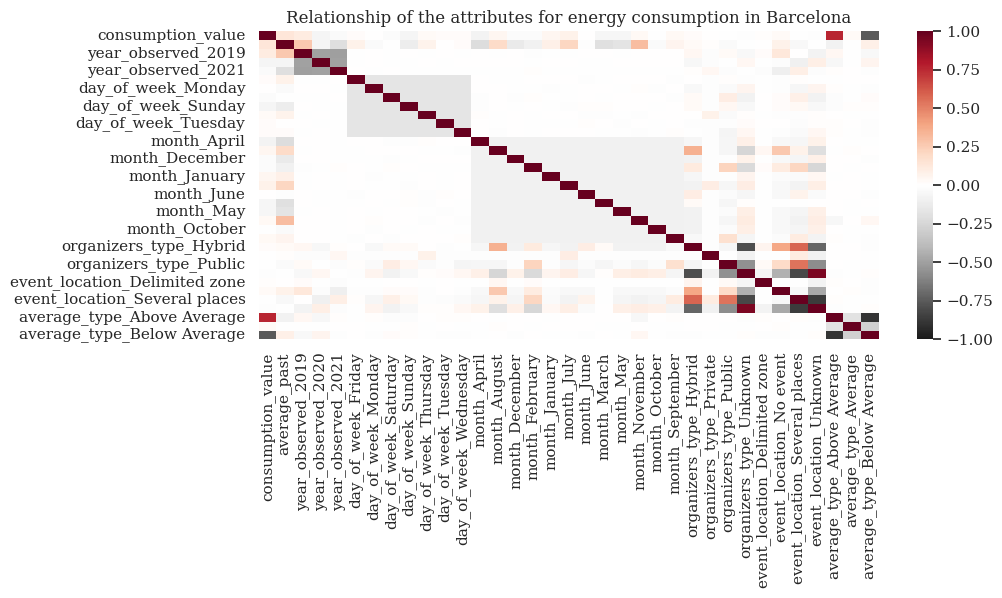

In [31]:
plt.figure(figsize=(10,4))
sns.set_theme(style="white",font='serif')
cor = X_pre.corr()
sns.heatmap(cor, annot=False, vmin=-1, vmax=1, cmap="RdGy_r") 
plt.title('Relationship of the attributes for energy consumption in Barcelona')
plt.show()

In [66]:
models = []
results = []
names = []

In [67]:
models.append(("Gaussian Naive Bayes:", GaussianNB()))
models.append(("Multinomial Naive Bayes:", MultinomialNB()))
models.append(("K-Nearest Neighbour:", KNeighborsClassifier(n_neighbors = 5)))
models.append(("Support Vector Machine → linear:", SVC(kernel = "linear")))
models.append(("Support Vector Machine → rbf:", SVC(kernel = "rbf")))

In [68]:
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 0, shuffle = True)
    cv_result = cross_val_score(model, X_scaled_train, y_train.values.ravel(), cv = kfold, scoring = "accuracy",error_score='raise')
    names.append(name)
    results.append(cv_result)

In [69]:
print('Accuracy from KFold - Cross Validation\r\n')
for i in range(len(names)):
    print(names[i],results[i].mean()*100)

Accuracy from KFold - Cross Validation

Gaussian Naive Bayes: 100.0
Multinomial Naive Bayes: 100.0
K-Nearest Neighbour: 99.45531637312459
Support Vector Machine → linear: 100.0
Support Vector Machine → rbf: 100.0


In [70]:
newColumn=np.zeros(len(X_scaled_train),dtype=np.int8)
columns_to_insert_X_pretest = ['year_observed_2023']
for col_name in columns_to_insert_X_pretest:
    X_scaled_train[col_name] = newColumn

In [71]:
gnb = GaussianNB()

#Model fitting
gnb.fit(X_scaled_train, y_train)
 
#Making predictions on the testing set
gnb_pred = gnb.predict(X_scaled_test)

In [72]:
print("Gaussian Naive Bayes Model Accuracy(in %):", accuracy_score(y_validate, gnb_pred)*100)
print("Gaussian Naive Bayes Model Precision(in %):", precision_score(y_validate, gnb_pred, average='weighted')*100)

Gaussian Naive Bayes Model Accuracy(in %): 85.71428571428571
Gaussian Naive Bayes Model Precision(in %): 100.0


In [73]:
print("Number of mislabeled points out of a total %d points : %d"
  % (X_scaled_test.shape[0], (y_validate != gnb_pred).sum()))

Number of mislabeled points out of a total 84 points : 12


In [74]:
print('↓AVG', '↑AVG')
print(confusion_matrix(y_validate, gnb_pred))

↓AVG ↑AVG
[[ 0  0]
 [12 72]]


In [75]:
print("Classification Report:")
print(classification_report(y_validate, gnb_pred))

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         0
 Not Average       1.00      0.86      0.92        84

    accuracy                           0.86        84
   macro avg       0.50      0.43      0.46        84
weighted avg       1.00      0.86      0.92        84



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
mltn=MultinomialNB()

mltn_scoring_list = {'precision_multiclass': make_scorer(precision_score, average='weighted')}
mltn_cv_results = cross_validate(mltn, X_scaled_train, y_train, cv = 3, scoring = mltn_scoring_list)
mltn_cv_results

{'fit_time': array([0.00781393, 0.00492525, 0.00481629]),
 'score_time': array([0.00512481, 0.00494599, 0.00492787]),
 'test_precision_multiclass': array([1., 1., 1.])}

In [77]:
mltn.fit(X_scaled_train,y_train)
mltn_pred = mltn.predict(X_scaled_test)
print("Multinomial Naive Bayes Model Accuracy(in %):", np.mean(mltn_pred == y_validate)*100)
print("Multinomial Naive Bayes Model Precision(in %):", precision_score(y_validate, mltn_pred, average='weighted')*100)

Multinomial Naive Bayes Model Accuracy(in %): 85.71428571428571
Multinomial Naive Bayes Model Precision(in %): 100.0


In [78]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled_train)

neighborhood=neigh.kneighbors(n_neighbors=5, return_distance=False)
len(neighborhood)

neighborhood[0:10]

array([[  5,  26, 120,  19,  92],
       [ 15, 128,  12, 135,  30],
       [  9,  23,  27,   8, 305],
       [ 17,  24,  10,  20,  25],
       [ 39, 300, 265,  25,  41],
       [ 26,  19,   0, 160, 125],
       [ 13, 176,  30, 126,  12],
       [ 28,  21,  14,   8,  27],
       [ 29,  22,  27,   2,   7],
       [ 23,   2,  17,  28,  29]])

In [79]:
clf_knn = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
results = cross_val_score(clf_knn, X_scaled_train, y_train, cv=9)
print(results.mean(), results.std())

0.9816075614743878 0.02003675695274927


In [80]:
clf_knn.get_params().keys()
parameters = {'metric':['manhattan','euclidean'],'n_neighbors': np.arange(3, 10, step = 2), 'weights':['uniform','distance']}

bestClassifier = GridSearchCV(clf_knn, parameters, cv=9)
bestClassifier.fit(X_scaled_train,y_train)
bestClassifier.best_params_

{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}

In [81]:
clf_knn.fit(X_scaled_train, y_train)
knn_pred = clf_knn.predict(X_scaled_test)
print("K Nearest Neighbors Model Test Accuracy(in %):", np.mean(knn_pred == y_validate)*100)
print("K Nearest Neighbors Model Test Precision(in %):", precision_score(y_validate, knn_pred, average='weighted')*100)

K Nearest Neighbors Model Test Accuracy(in %): 88.09523809523809
K Nearest Neighbors Model Test Precision(in %): 100.0


In [82]:
print("Number of mislabeled points out of a total %d points : %d"
  % (X_scaled_test.shape[0], (y_validate != knn_pred).sum()))

Number of mislabeled points out of a total 84 points : 10


In [83]:
print('↓AVG', '↑AVG')
print(confusion_matrix(y_validate, knn_pred))

↓AVG ↑AVG
[[ 0  0]
 [10 74]]


In [132]:
pip install mlxtend

  Using cached mlxtend-0.22.0-py2.py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


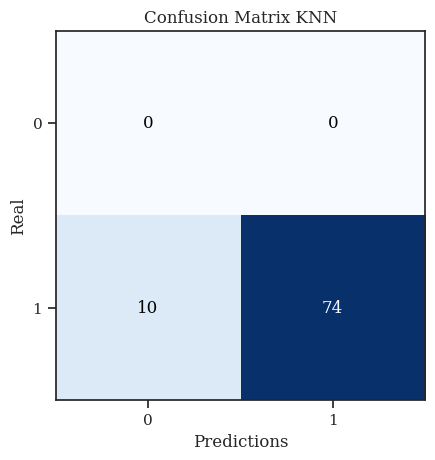

In [136]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_validate, knn_pred))
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.title('Confusion Matrix KNN')
plt.show()

In [84]:
print("Classification Report:")
print(classification_report(y_validate, knn_pred))

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         0
 Not Average       1.00      0.88      0.94        84

    accuracy                           0.88        84
   macro avg       0.50      0.44      0.47        84
weighted avg       1.00      0.88      0.94        84



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
#Create a svm Classifier
clf_svc = svm.SVC(kernel='linear',C=0.1, decision_function_shape = 'ovo') # Linear Kernel

#Train the model using the training sets
clf_svc.fit(X_scaled_train, y_train)

#Predict the response for test dataset
svc_pred = clf_svc.predict(X_scaled_test)

In [86]:
print("SVM - Linear Model Test Accuracy(in %):", np.mean(svc_pred == y_validate)*100)
print("SVM - Linear Model Test Precision(in %):", precision_score(y_validate, svc_pred, average='weighted')*100)

SVM - Linear Model Test Accuracy(in %): 85.71428571428571
SVM - Linear Model Test Precision(in %): 100.0


In [87]:
print("Number of mislabeled points out of a total %d points : %d"
  % (X_scaled_test.shape[0], (y_validate != svc_pred).sum()))

Number of mislabeled points out of a total 84 points : 12


In [88]:
print('↓AVG', '↑AVG')
print(confusion_matrix(y_validate, svc_pred))

↓AVG ↑AVG
[[ 0  0]
 [12 72]]


In [90]:
print("Intercept (b): ", clf_svc.intercept_)

Intercept (b):  [0.33279242]


Intercept (b):  [0.33343237]

In [91]:
from sklearn.ensemble import RandomForestClassifier

#rf = RandomForestClassifier(n_estimators=10000, oob_score=True, warm_start=True, max_depth=32, min_samples_split=17, min_samples_leaf=5, max_features=12)
rf = RandomForestClassifier(n_estimators=100, max_features=9, warm_start=True, min_samples_split=8, min_samples_leaf=4, max_depth=50, bootstrap=False)
rf.fit(X_scaled_train, y_train)
rf_pred = rf.predict(X_scaled_test)
#print(rf.oob_score_)
# Evaluate the accuracy on the testing data
accuracy = accuracy_score(y_validate, rf_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 85.71%


In [92]:
print("Number of mislabeled points out of a total %d points : %d"
  % (X_scaled_test.shape[0], (y_validate != rf_pred).sum()))

Number of mislabeled points out of a total 84 points : 12


In [93]:
print('↓AVG', '↑AVG')
print(confusion_matrix(y_validate, rf_pred))

↓AVG ↑AVG
[[ 0  0]
 [12 72]]


In [94]:
print("Classification Report:")
print(classification_report(y_validate, rf_pred))

Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         0
 Not Average       1.00      0.86      0.92        84

    accuracy                           0.86        84
   macro avg       0.50      0.43      0.46        84
weighted avg       1.00      0.86      0.92        84



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


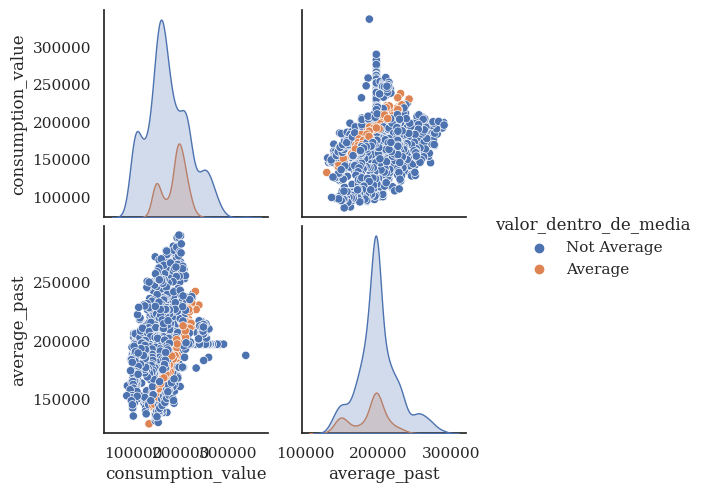

In [105]:
sns.pairplot(df[['consumption_value','average_past','valor_dentro_de_media']],hue='valor_dentro_de_media')

Text(0.5, 1.0, 'Feature Importances performing the RF method')

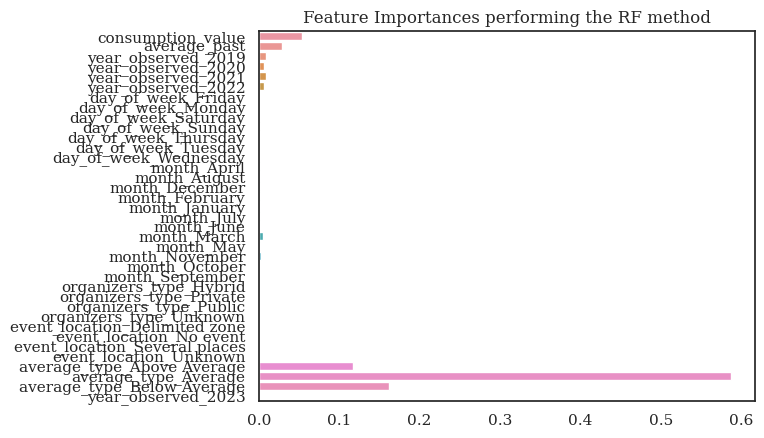

In [104]:
sns.barplot(y = X_scaled_train.columns, x = rf.feature_importances_)
plt.title('Feature Importances performing the RF method')

In [111]:
y_train_encoded = [0 if label == 'Average' else 1 for label in y_train]
y_validate_encoded = [0 if label == 'Average' else 1 for label in y_validate]

# Crea el modelo XGBoost
model_xgb = xgb.XGBClassifier(objective='binary:logistic',booster='gbtree')

# Entrena el modelo con las etiquetas codificadas
model_xgb.fit(X_scaled_train, y_train_encoded)

# Realiza predicciones en el conjunto de prueba
xgb_pred = model_xgb.predict(X_scaled_test)

# Calcula la precisión
accuracy = accuracy_score(y_validate_encoded, xgb_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 85.71%


In [112]:
print("Number of mislabeled points out of a total %d points : %d"
  % (X_scaled_test.shape[0], (y_validate_encoded != xgb_pred).sum()))

Number of mislabeled points out of a total 84 points : 12


In [114]:
print('↓AVG', '↑AVG')
print(confusion_matrix(y_validate_encoded, xgb_pred))

↓AVG ↑AVG
[[ 0  0]
 [12 72]]


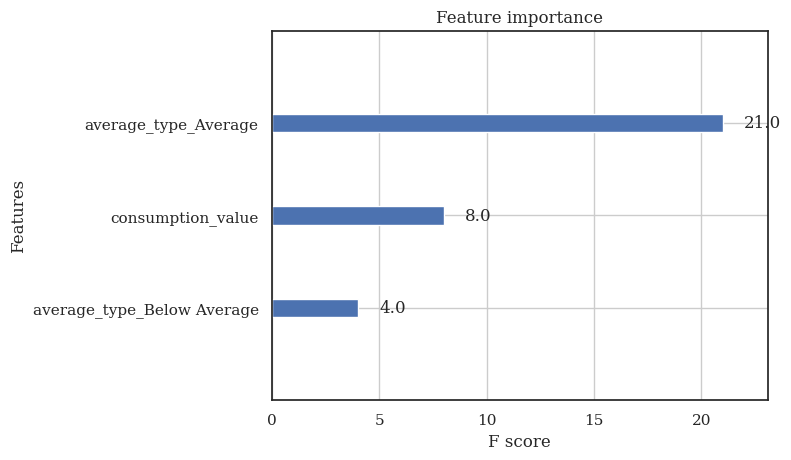

In [115]:
xgb.plot_importance(model_xgb)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

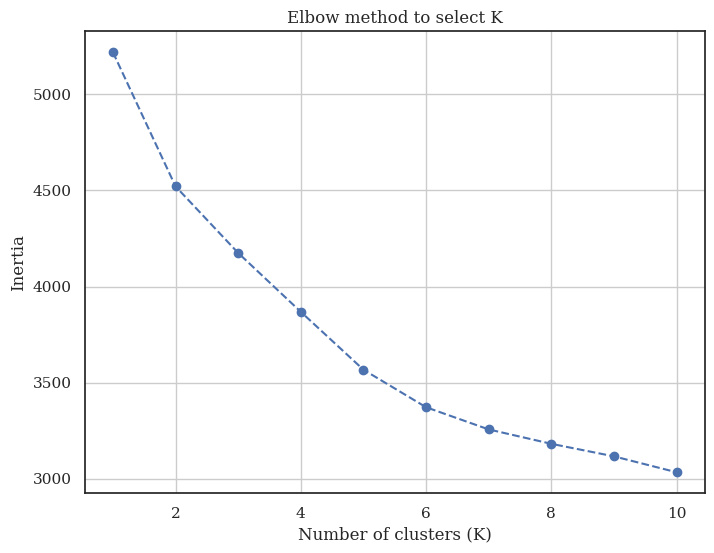

In [117]:
K = 10
inertia = []
for k in range(1, K+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled_train)
    inertia.append(kmeans.inertia_)

# Graficar la inercia en función de K para ayudar a seleccionar el número adecuado
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow method to select K')
plt.grid(True)
plt.show()

In [118]:
kmeans = KMeans(n_clusters=K)
cluster_labels = kmeans.fit_predict(X_scaled_train)

num_random_clusters = 100  # Number of random perturbed clusters

random_clusters = []
for _ in range(num_random_clusters):
    # Shuffle the data
    shuffled_data = np.random.permutation(X_scaled_train)
    
    # Perform K-means clustering on shuffled data
    random_kmeans = KMeans(n_clusters=K)
    random_cluster_labels = random_kmeans.fit_predict(shuffled_data)
    random_clusters.append(random_cluster_labels)
    
def prediction_strength(cluster_labels, random_clusters):
    num_instances = len(cluster_labels)
    num_random_clusters = len(random_clusters)
    agree_count = 0

    for i in range(num_instances):
        agreement = 0
        for j in range(num_random_clusters):
            if cluster_labels[i] == random_clusters[j][i]:
                agreement += 1
        agree_count += (agreement / num_random_clusters)

    return (agree_count / num_instances)

ps_value = prediction_strength(cluster_labels, random_clusters)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

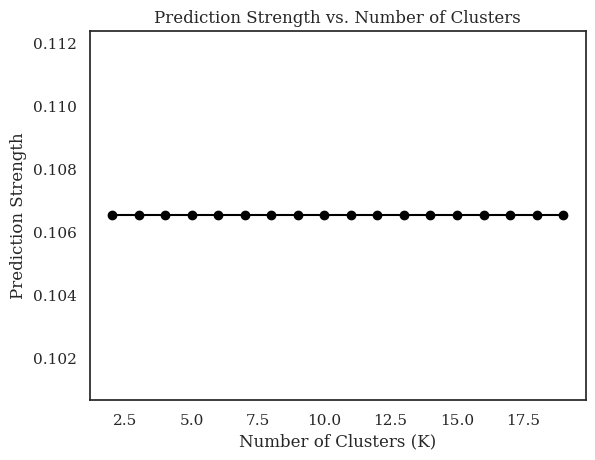

In [119]:
threshold = 0.70

# Assuming ps_value is a single float representing prediction strength
ps_value = prediction_strength(cluster_labels, random_clusters)

# Create a list of cluster numbers (K values)
clusters = list(range(2, 20))  # Modify the range as needed

# Create a list of prediction strength values (all the same since ps_value is a scalar)
ry = [ps_value] * len(clusters)

# Plot the prediction strength
_, ax = plt.subplots()
ax.plot(clusters, ry, '-o', color='black')

# Add labels and titles
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Prediction Strength')
plt.title('Prediction Strength vs. Number of Clusters')

# Show the plot
plt.show()

In [120]:
import math
threshold = 0.70
k_optimal = -math.inf
s_optimal = -math.inf
centroids = []

exceeds_threshold = (results > threshold).any()

if exceeds_threshold:
    # Handle the case where at least one element exceeds the threshold
    # You can find the index of the first element that exceeds the threshold using results.argmax()
    k_optimal = results.argmax() + 1  # Add 1 to convert from 0-based index to K value
    s_optimal = results.max()
    centroids = kmeans.cluster_centers_  # Set the centroids (empty list or appropriate value)
else:
    # Handle the case where no element exceeds the threshold
    k_optimal = -math.inf
    s_optimal = -math.inf
    centroids = []

# Print or use k_optimal, s_optimal, and centroids as needed
print(f"Optimal K: {k_optimal}")
print(f"Optimal Prediction Strength: {s_optimal}")
print(f"Optimal Centroids: {centroids}")

Optimal K: 2
Optimal Prediction Strength: 1.0
Optimal Centroids: [[ 2.36935556e-01  3.89296778e-01  5.26315789e-03 -2.49800181e-16
   2.22044605e-16  9.94736842e-01  1.42105263e-01  1.52631579e-01
   1.26315789e-01  1.89473684e-01  1.15789474e-01  1.52631579e-01
   1.21052632e-01  1.05263158e-02  8.94736842e-02  8.94736842e-02
   1.00000000e-01  1.63157895e-01  9.47368421e-02  3.15789474e-02
   6.31578947e-02 -2.77555756e-16  1.57894737e-01  1.63157895e-01
   3.68421053e-02 -6.93889390e-17  7.58941521e-19 -4.16333634e-17
   1.00000000e+00 -8.67361738e-18 -1.73472348e-17  2.91433544e-16
   1.00000000e+00 -7.21644966e-16  3.05311332e-16  1.00000000e+00
   0.00000000e+00]
 [ 5.79921213e-01  4.27034634e-01  8.90295359e-01  1.09704641e-01
   6.10622664e-16  2.77555756e-17  1.60337553e-01  1.47679325e-01
   1.35021097e-01  6.32911392e-02  1.64556962e-01  1.60337553e-01
   1.68776371e-01 -6.93889390e-17  6.75105485e-02  8.01687764e-02
   7.59493671e-02  1.85654008e-01  1.30801688e-01  8.86075

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


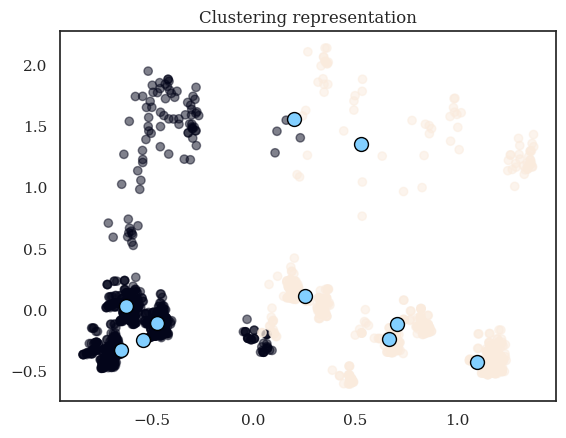

<Figure size 640x480 with 0 Axes>

In [121]:
from sklearn.decomposition import PCA
if centroids is None:
    print("No centroids defined")
PCA_model = PCA(n_components=2).fit(X_scaled_train.to_numpy())
labels = KMeans(n_clusters=k_optimal, random_state=73).fit(X_scaled_train.to_numpy()).labels_
# Function to plot current state of the algorithm.
# For visualisation purposes, only the first two PC are shown.
PC = PCA_model.transform(X_scaled_train.to_numpy())
C2 = PCA_model.transform(centroids)
ax = plt.scatter(PC[:,0], PC[:,1], c=labels, alpha=0.5)
ax = plt.scatter(C2[:,0], C2[:,1], c='#82cfff', s=100, edgecolors = 'black')
ax = plt.title("Clustering representation")
ax = plt.show()
ax = plt.clf()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


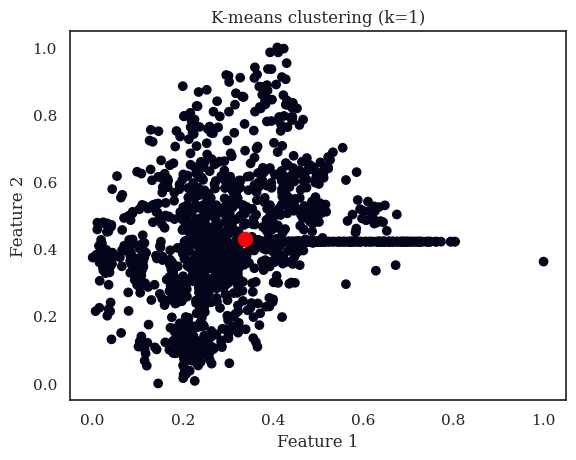

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


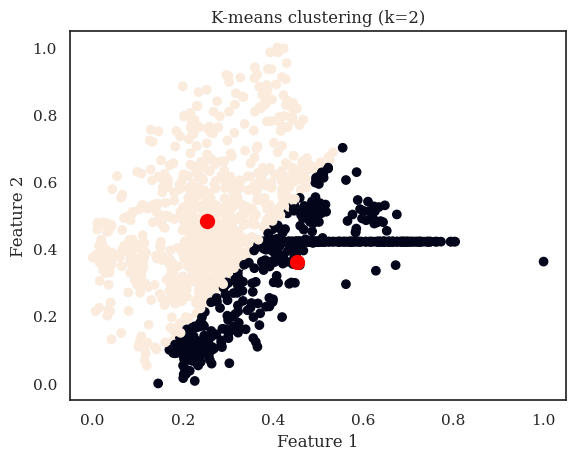

In [123]:
k_range = range(1, 3)
 
# Initialize an empty list to
# store the inertia values for each k
inertia_values = []
 
# Fit and plot the data for each k value
for k in k_range:
    kmeans = KMeans(n_clusters=k, \
                    init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(X_scaled_train)
    inertia_values.append(kmeans.inertia_)
    plt.scatter(X_scaled_train['consumption_value'], X_scaled_train['average_past'], c=y_kmeans)
    plt.scatter(kmeans.cluster_centers_[:, 0],\
                kmeans.cluster_centers_[:, 1], \
                s=100, c='red')
    plt.title('K-means clustering (k={})'.format(k))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [124]:
kmeans.cluster_centers_

array([[ 4.53846848e-01,  3.61288938e-01,  5.24038462e-01,
         8.33333333e-02,  1.57051282e-01,  2.35576923e-01,
         1.50641026e-01,  1.34615385e-01,  1.53846154e-01,
         8.17307692e-02,  1.53846154e-01,  1.58653846e-01,
         1.66666667e-01,  1.00961538e-01,  7.53205128e-02,
         7.37179487e-02,  6.25000000e-02,  9.29487179e-02,
         8.33333333e-02,  1.07371795e-01,  9.45512821e-02,
         1.18589744e-01,  4.80769231e-02,  5.12820513e-02,
         9.13461538e-02,  8.33333333e-02, -2.92734587e-18,
         4.64743590e-02,  8.70192308e-01,  1.12179487e-02,
         3.20512821e-02,  8.65384615e-02,  8.70192308e-01,
         5.92948718e-01,  4.07051282e-01, -3.55271368e-15,
         0.00000000e+00],
       [ 2.52585863e-01,  4.82309096e-01,  4.73933649e-02,
         3.72037915e-01,  3.19905213e-01,  2.60663507e-01,
         1.37440758e-01,  1.46919431e-01,  1.36255924e-01,
         1.90758294e-01,  1.33886256e-01,  1.30331754e-01,
         1.24407583e-01,  6.75

In [125]:
kmeans.labels_

array([1, 0, 0, ..., 0, 1, 1], dtype=int32)

In [126]:
pca=PCA(n_components=2)
 
reduced_X=pd.DataFrame(data=pca.fit_transform(X_scaled_train),columns=['PCA1','PCA2'])
 
#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.07,-0.32
1,0.86,-0.18
2,1.18,-0.45
3,1.18,-0.43
4,1.33,1.18


In [127]:
centers=pca.transform(kmeans.cluster_centers_)
 
# reduced centers
centers

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[ 0.77800353,  0.00209275],
       [-0.5752064 , -0.00154725]])

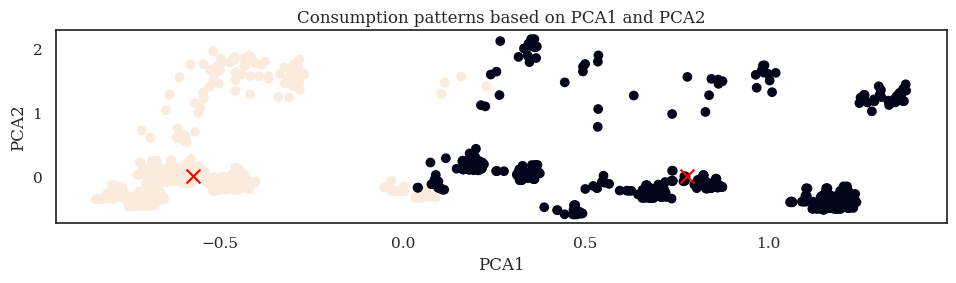

In [128]:
plt.figure(figsize=(10,3))
 
# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Consumption patterns based on PCA1 and PCA2')
plt.tight_layout()

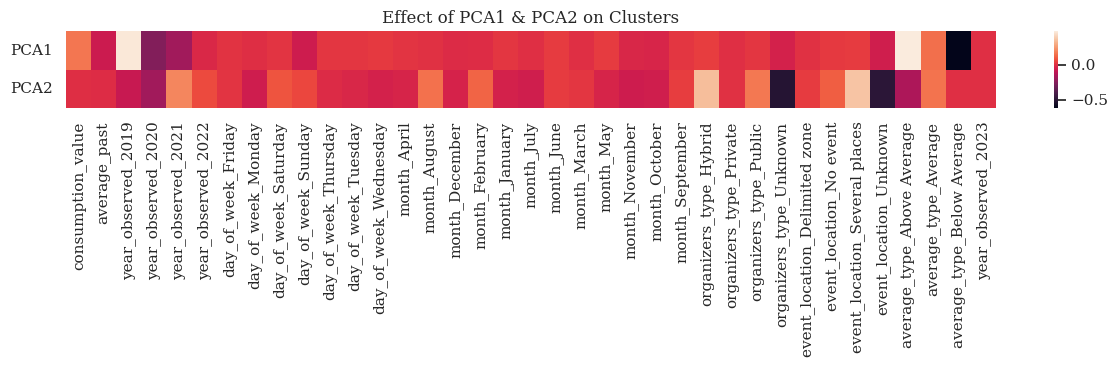

In [130]:
plt.figure(figsize=(15,1))
component_df=pd.DataFrame(pca.components_,index=['PCA1',"PCA2"],columns=X_scaled_train.columns)
# Heat map
sns.heatmap(component_df)
plt.title('Effect of PCA1 & PCA2 on Clusters')
plt.show()

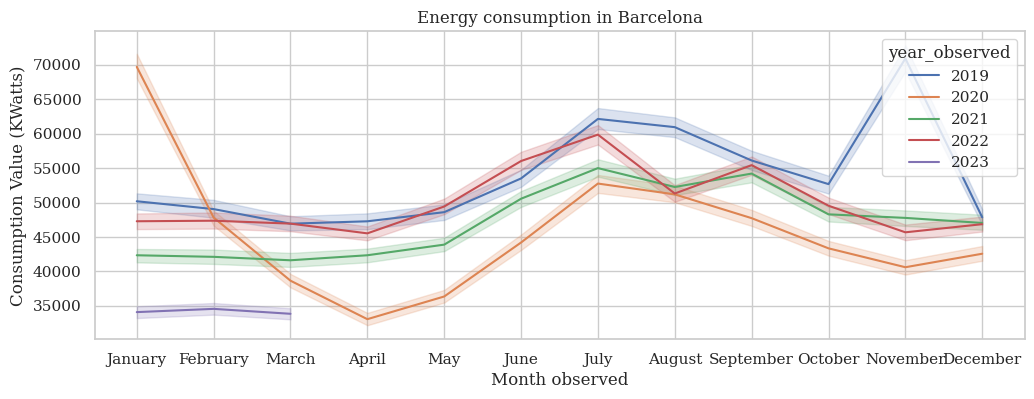

In [10]:
rcParams['figure.figsize'] = 12,4
sns.lineplot(x="month", y="consumption_value",
             hue="year_observed",
             data=df)
sns.set_theme(style="white",font='serif')
plt.xlabel('Month observed')
plt.ylabel('Consumption Value (KWatts)')
plt.title('Energy consumption in Barcelona') 
plt.show()

<Figure size 1200x400 with 0 Axes>

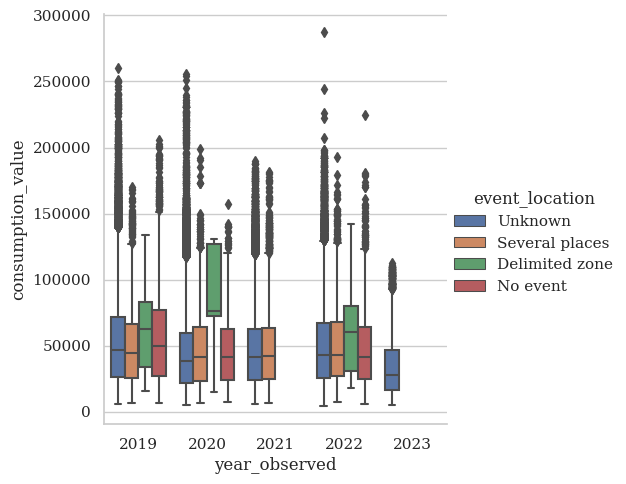

In [9]:
plt.figure(figsize=(12,4))
ax = sns.catplot(data=df, x="year_observed", y="consumption_value", hue="event_location", kind="box")
plt.show()

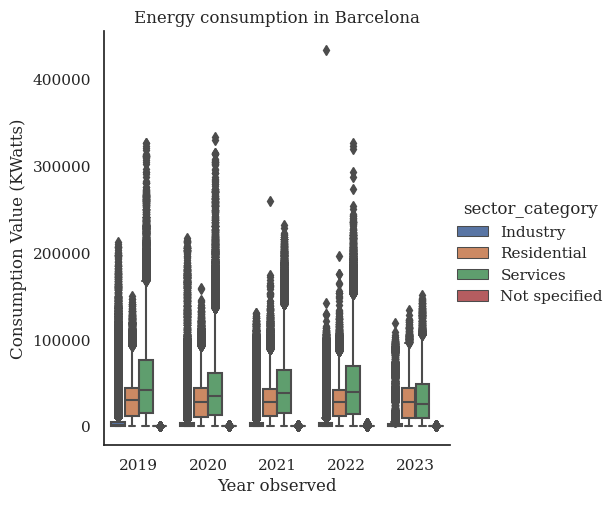

In [13]:
rcParams['figure.figsize'] = 12,4
sns.catplot(data=data, x="year_observed", y="consumption_value", hue="sector_category", kind="box")
sns.set_theme(style="white",font='serif')
plt.xlabel('Year observed')
plt.ylabel('Consumption Value (KWatts)') 
plt.title('Energy consumption in Barcelona') 
plt.show()